In [310]:
# You may need these
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from tqdm import tqdm


import matplotlib.pyplot as plt
%matplotlib inline

# load the dataset

In [ ]:
dataset_name = "grp9dataset.csv"

df = pd.read_csv(dataset_name)
drops = ["Sation", "Period", "From Date", "To Date"]

# for i in df.columns[df.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
#     df[i].fillna(df[i].mean(),inplace=True)

df = df.drop(drops, axis='columns')[df.SO2 != '-']
df = df.fillna(0)
df.head()



In [314]:
def seperate_dataset(data, target):
  X = data[['Latitude', 'Longitude']]
  y = data[target].values
  return X, y

datasets = {}

for target in df.columns[2:]:
  X, y = seperate_dataset(df, target)
  test_size = 0.2

  # Splitting code here
  xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
  datasets[target] = (xtrain, xtest, ytrain, ytest)


In [316]:
# Train
def get_model():
  model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    # ('scaler', StandardScaler()),
    ('model', ElasticNet(alpha=0.3, l1_ratio=0.5))
    # ('model', LinearRegression())
  ])

  return model

In [322]:
# Evaluate
def evaluate_model(model, xtrain, ytrain, xtest, ytest):
  cvs = cross_val_score(model, xtrain, ytrain, cv=5, scoring="r2").mean()
  train_score = model.score(xtrain, ytrain)
  test_score = model.score(xtest, ytest)

  return cvs, train_score, test_score

def log_results(name, cvs, train_score, test_score):
  print(name)
  print("CVS:", cvs)
  print("Train score:", train_score)
  print("Test score:", test_score)

In [320]:
def train_model(name, xtrain, ytrain, xtest, ytest):
  model = get_model()
  model.fit(xtrain, ytrain)
  cvs, train_score, test_score = evaluate_model(model, xtrain, ytrain, xtest, ytest)
  log_results(name, cvs, train_score, test_score)
  return model


In [387]:
# Generate and train main model

gas_to_train = "NO2"

X = df.loc[:, df.columns != gas_to_train]
y = df[gas_to_train].values

test_size = 0.2
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)

Model = train_model("all", xtrain, ytrain, xtest, ytest)

all
CVS: -1.8240102652293508
Train score: 0.9905533903039317
Test score: -7.92481517470442


/Users/maaz/Desktop/coding/Uni/DATASCI3000/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.788e+01, tolerance: 1.298e+00
  model = cd_fast.enet_coordinate_descent(
/Users/maaz/Desktop/coding/Uni/DATASCI3000/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.285e+01, tolerance: 1.113e+00
  model = cd_fast.enet_coordinate_descent(
/Users/maaz/Desktop/coding/Uni/DATASCI3000/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, c

In [ ]:
gases = list(datasets.keys())
models = {}

for i in tqdm(range(len(gases))):
  target = gases[i]

  xtrain, xtest, ytrain, ytest = datasets[target]
  model = get_model()
  model.fit(xtrain, ytrain)

  models[target] = model

for gas, model in models.items():
  print(gas)

  xtrain, xtest, ytrain, ytest = datasets[gas]
  cvs, train_score, test_score = evaluate_model(model, xtrain, ytrain, xtest, ytest)
  log_results(gas, cvs, train_score, test_score)



In [362]:
def get_prediction(lat, long):
  x = [lat, long]

  for gas in gases:
    if gas == gas_to_train:
      continue

    model = models[gas]
    y = model.predict(np.array([lat, long]).reshape(1, -1))
    x.append(float(y))

  x = np.array(x).reshape(1, -1)
  y = Model.predict(x)
  return float(y)


In [388]:
min_lat = min(df.Latitude)
max_lat = max(df.Latitude)
min_long = min(df.Longitude)
max_long = max(df.Longitude)

step = 0.025
lat_range = int((max_lat - min_lat) / step)
long_range = int((max_long - min_long) / step)

lat = min_lat
long = min_long

predictions = [[0 for i in range(long_range)] for j in range(lat_range)]

for i in tqdm(range(lat_range)):
  for j in tqdm(range(long_range)):
    lat = min_lat + i * step
    long = min_long + j * step
    y = get_prediction(lat, long)
    predictions[i][j] = y

print(predictions)

  0%|          | 0/12 [00:00<?, ?it/s]/Users/maaz/Desktop/coding/Uni/DATASCI3000/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/var/folders/pg/ymqqw26j6n12rym1w1bfndsm0000gn/T/ipykernel_96288/4067630047.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x.append(float(y))
/Users/maaz/Desktop/coding/Uni/DATASCI3000/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/var/folders/pg/ymqqw26j6n12rym1w1bfndsm0000gn/T/ipykernel_96288/4067630047.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure y

[[40, 38, 37, 36, 35, 34, 33, 32, 31, 31, 30, 29, 28, 28, 27], [41, 40, 39, 38, 37, 37, 36, 35, 35, 34, 34, 33, 32, 32, 32], [41, 41, 40, 40, 39, 38, 38, 38, 37, 37, 37, 36, 36, 36, 36], [41, 41, 40, 40, 40, 40, 39, 39, 39, 39, 39, 39, 39, 39, 39], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 42], [39, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 43, 43], [36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 42, 42, 43, 44, 45], [34, 34, 35, 35, 36, 37, 38, 38, 39, 40, 41, 42, 43, 44, 45], [30, 31, 32, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45], [26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 41, 43, 44], [20, 22, 23, 25, 26, 27, 29, 31, 32, 34, 35, 37, 39, 41, 42], [15, 16, 18, 20, 21, 23, 25, 27, 28, 30, 32, 34, 36, 38, 40]]


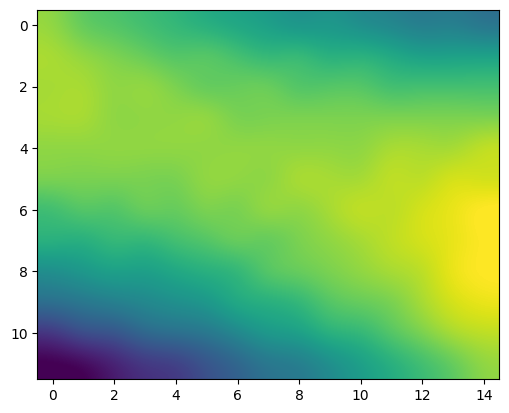

In [389]:
plt.imshow(predictions, cmap='viridis', interpolation='spline36')
plt.show()


In [ ]:
matrices = {}

for i in tqdm(range(len(gases))):
  gas = gases[i]
  matrices[gas] = [[0 for i in range(100)] for j in range(100)]
  matrix = matrices[gas]
  model = models[gas]

  for i in tqdm(range(100)):
    for j in tqdm(range(100)):
      x = np.array([i, j]).reshape(1, -1)
      y = model.predict(x)
      matrix[i][j] = int(y)


# Testing

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, gas in zip(axs.flat, gases):
    ax.imshow(matrices[gas], cmap='viridis', interpolation='nearest')
    ax.set_title(gas)

plt.tight_layout()
plt.show()

In [28]:
# # Calculate performance measures from scratch
# # TP: true postives
# # TN: true negatives
# # FP: False positives
# # FN: False negatives
# def compute_performance(yhat, y, classes):
#     # First, get tp, tn, fp, fn
#     tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
#     tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
#     fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
#     fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

#     print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")

#     # Accuracy
#     acc = (tp + tn) / (tp + tn + fp + fn)

#     # Precision
#     # "Of the ones I labeled +, how many are actually +?"
#     precision = tp / (tp + fp)

#     # Recall
#     # "Of all the + in the data, how many do I correctly label?"
#     recall = tp / (tp + fn)

#     # Sensitivity
#     # "Of all the + in the data, how many do I correctly label?"
#     sensitivity = recall

#     # Specificity
#     # "Of all the - in the data, how many do I correctly label?"
#     specificity = tn / (fp + tn)

#     # Print results

#     print("Accuracy:",round(acc,3),"Recall:",round(recall,3),"Precision:",round(precision,3),
#           "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))